In [ ]:
  import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models
from typing import Tuple
tf.compat.v1.enable_eager_execution()


os.environ["cuda_visible_devices"]="0" 

from glob import glob
import io
from PIL import Image

import math, re, os
import numpy as np

from collections import Counter
from imblearn.over_sampling import RandomOverSampler

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [ ]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

Default GPU Device:/device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Print a flower image in training data

In [ ]:
raw_dataset = glob("/content/drive/MyDrive/Colab_Notebooks/ML_data/tfrecords-jpeg-192x192/train/00-192x192-798.tfrec")

In [ ]:
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
}

In [ ]:
def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

In [ ]:
raw_image_dataset = tf.data.TFRecordDataset(raw_dataset)
monet_image_dataset = raw_image_dataset.map(_parse_image_function)

Display flower image...


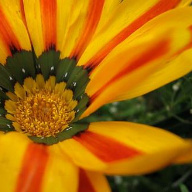

In [ ]:
print('Display flower image...')
for e in monet_image_dataset.take(6):
    image = Image.open(io.BytesIO(e['image'].numpy()))
image

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
img_array = np.array(image)
print(len(img_array))

192


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
IMAGE_SIZE = [192, 192]
GCS_PATH = '/content/drive/MyDrive/Colab_Notebooks/combined_data/*.tfrec'

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

FILENAMES = tf.io.gfile.glob(GCS_PATH)

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def encode_image(image, label):
    image = tf.cast(image, tf.float32) * 255.0
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image)
    return image, label

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
      value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(image_string, label):
    feature = {
      'class': _int64_feature(label),
      'image': _bytes_feature(image_string),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def tf_serialize_example(f0,f1):
    tf_string = tf.py_function(
      serialize_example,
      (f0, f1),  # Pass these args to the above function.
      tf.string)      # The return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar.


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [ ]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image, cmap = 'gray')
    #plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])


In [ ]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_dataset():
    dataset = load_dataset(FILENAMES, labeled=True)
    # dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    # dataset = dataset.repeat() # the training dataset must repeat for several epochs
    # dataset = dataset.shuffle(2048)
    # dataset = dataset.batch(BATCH_SIZE)
    # dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_trainning_dataset(dataset):
    # ignore_order = tf.data.Options()
    # ignore_order.experimental_deterministic = False
    # dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    # dataset = dataset.shuffle(6536)
    dataset = dataset.batch(16)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset):
    # ignore_order = tf.data.Options()
    # ignore_order.experimental_deterministic = False
    # dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(dataset):
    # ignore_order = tf.data.Options()
    # ignore_order.experimental_deterministic = False
    # dataset = dataset.with_options(ignore_order)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def split_dataset(dataset: tf.data.Dataset, 
                  dataset_size: int, 
                  train_ratio: float, 
                  validation_ratio: float) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    assert (train_ratio + validation_ratio) < 1

    train_count = int(dataset_size * train_ratio)
    validation_count = int(dataset_size * validation_ratio)
    test_count = dataset_size - (train_count + validation_count)

    dataset = dataset.shuffle(dataset_size, reshuffle_each_iteration=False)

    train_dataset = dataset.take(train_count)
    validation_dataset = dataset.skip(train_count).take(validation_count)
    test_dataset = dataset.skip(validation_count + train_count).take(test_count)

    return train_dataset, validation_dataset, test_dataset

NUM_IMAGES = count_data_items(FILENAMES)
print('Dataset: {} training images'.format(NUM_IMAGES))

Dataset: 16465 training images


In [ ]:
ds = get_dataset()

print("Training:", ds)

Training: <ParallelMapDataset element_spec=(TensorSpec(shape=(192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


In [ ]:
# c = next(iter(ds_train.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()
# unique, counts = np.unique(c, return_counts=True)
# flowers_counts = dict(zip(unique, counts))
# flowers_counts

In [ ]:
# plt.figure(figsize = (20, 10))
# plt.bar(flowers_counts.keys(), flowers_counts.values())
# plt.title("Distribution of Flower Classes in Training Data", fontsize = 25)
# plt.xlabel("Flower Classes", fontsize = 15)
# plt.ylabel("Frequency of Instances", fontsize = 15)

In [ ]:
# c = next(iter(ds_valid.unbatch().map(lambda image, label: label).batch(NUM_VALIDATION_IMAGES))).numpy()
# unique, counts = np.unique(c, return_counts=True)
# flowers_counts = dict(zip(unique, counts))
# flowers_counts

In [ ]:
# plt.figure(figsize = (20, 10))
# plt.bar(flowers_counts.keys(), flowers_counts.values())
# plt.title("Distribution of Flower Classes in Validation Data", fontsize = 25)
# plt.xlabel("Flower Classes", fontsize = 15)
# plt.ylabel("Frequency of Instances", fontsize = 15)

In [ ]:
# ds_iter = iter(ds_train.unbatch().batch(20))

In [ ]:
# one_batch = next(ds_iter)
# display_batch_of_images(one_batch)

In [ ]:
c = next(iter(ds.map(lambda image, label: label).batch(NUM_IMAGES))).numpy()
unique, counts = np.unique(c, return_counts=True)
flowers_counts = dict(zip(unique, counts))
sum(flowers_counts.values())

16465

Text(0, 0.5, 'Frequency of Instances')

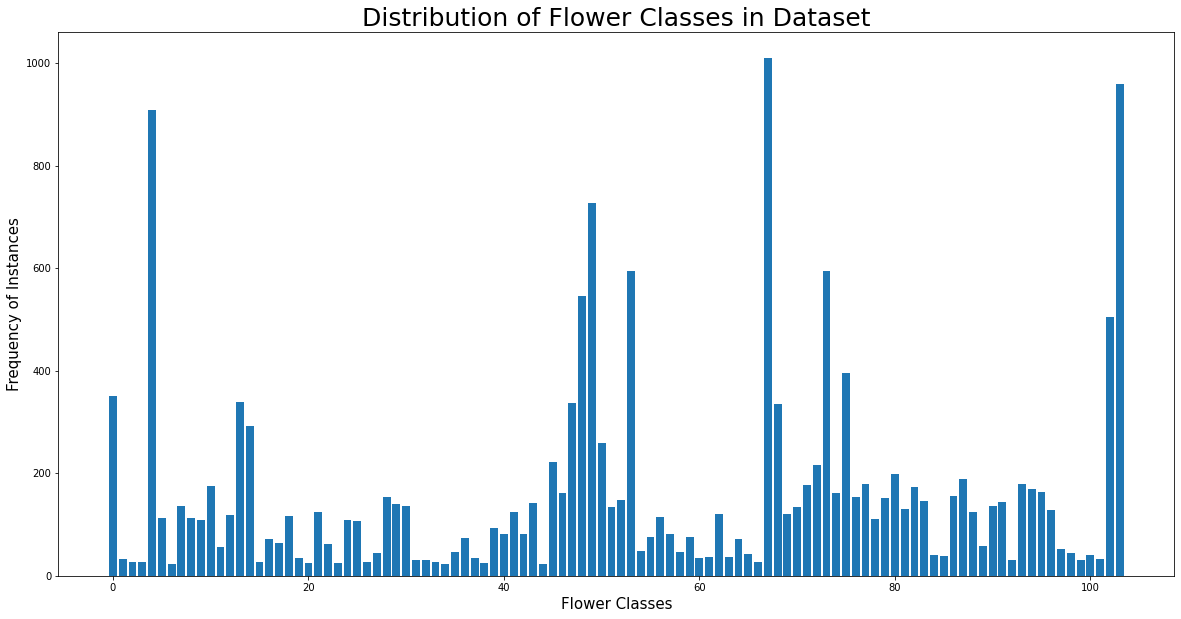

In [ ]:
plt.figure(figsize = (20, 10))
plt.bar(flowers_counts.keys(), flowers_counts.values())
plt.title("Distribution of Flower Classes in Dataset", fontsize = 25)
plt.xlabel("Flower Classes", fontsize = 15)
plt.ylabel("Frequency of Instances", fontsize = 15)

In [ ]:
marklist = sorted(flowers_counts.items(), key=lambda x:x[1])
sortdict = dict(marklist[::-1])
sortdict = {i: v for i,v in enumerate(sortdict.values())}
print(sortdict) 

{0: 1010, 1: 959, 2: 908, 3: 727, 4: 594, 5: 594, 6: 545, 7: 504, 8: 395, 9: 351, 10: 340, 11: 337, 12: 336, 13: 293, 14: 259, 15: 222, 16: 216, 17: 198, 18: 189, 19: 180, 20: 180, 21: 177, 22: 176, 23: 173, 24: 169, 25: 164, 26: 162, 27: 161, 28: 155, 29: 154, 30: 153, 31: 152, 32: 148, 33: 145, 34: 143, 35: 142, 36: 141, 37: 137, 38: 136, 39: 136, 40: 135, 41: 134, 42: 130, 43: 129, 44: 124, 45: 124, 46: 124, 47: 121, 48: 120, 49: 119, 50: 116, 51: 115, 52: 112, 53: 112, 54: 111, 55: 109, 56: 108, 57: 107, 58: 94, 59: 82, 60: 81, 61: 81, 62: 75, 63: 75, 64: 74, 65: 71, 66: 71, 67: 64, 68: 62, 69: 59, 70: 56, 71: 53, 72: 48, 73: 47, 74: 46, 75: 44, 76: 44, 77: 42, 78: 40, 79: 40, 80: 38, 81: 37, 82: 36, 83: 35, 84: 34, 85: 34, 86: 33, 87: 32, 88: 31, 89: 31, 90: 31, 91: 30, 92: 27, 93: 27, 94: 27, 95: 27, 96: 26, 97: 26, 98: 25, 99: 25, 100: 24, 101: 23, 102: 23, 103: 23}


Text(0, 0.5, 'Frequency of Instances')

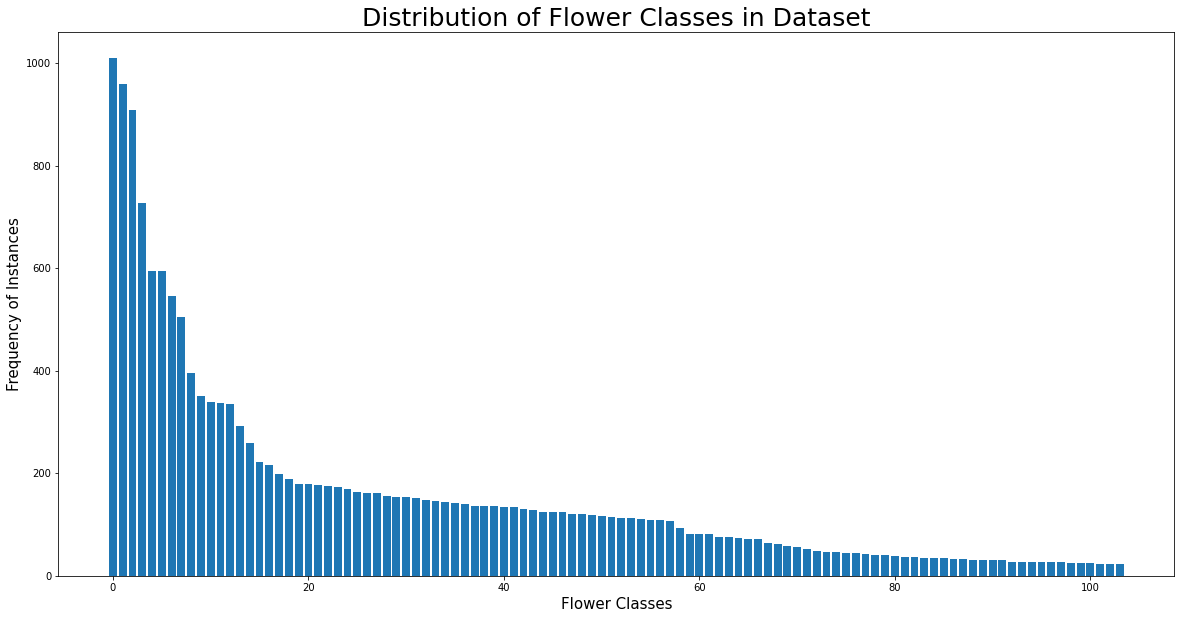

In [ ]:
plt.figure(figsize = (20, 10))
plt.bar(sortdict.keys(), sortdict.values())
plt.title("Distribution of Flower Classes in Dataset", fontsize = 25)
plt.xlabel("Flower Classes", fontsize = 15)
plt.ylabel("Frequency of Instances", fontsize = 15)

In [ ]:
sortdict.get(20)

180

In [ ]:
sortdict = {k:v for k, v in sortdict.items() if v >= 180}
sortdict

{0: 1010,
 1: 959,
 2: 908,
 3: 727,
 4: 594,
 5: 594,
 6: 545,
 7: 504,
 8: 395,
 9: 351,
 10: 340,
 11: 337,
 12: 336,
 13: 293,
 14: 259,
 15: 222,
 16: 216,
 17: 198,
 18: 189,
 19: 180,
 20: 180}

In [ ]:
fc = {k:v for k, v in flowers_counts.items() if v >= 180}

In [ ]:
fc = {k: v for k, v in sorted(fc.items(), key=lambda item: item[1])[::-1]}
fc

{0: 351,
 4: 908,
 13: 340,
 14: 293,
 45: 222,
 47: 337,
 48: 545,
 49: 727,
 50: 259,
 53: 594,
 67: 1010,
 68: 336,
 72: 216,
 73: 594,
 75: 395,
 77: 180,
 80: 198,
 87: 189,
 93: 180,
 102: 504,
 103: 959}

In [ ]:
fc.keys()

dict_keys([67, 103, 4, 49, 73, 53, 48, 102, 75, 0, 13, 47, 68, 14, 50, 45, 72, 80, 87, 93, 77])

In [ ]:
size_of_ds = sum(fc.values())
size_of_ds

9337

In [ ]:
fc_copy = fc.copy()

In [ ]:
ds_take = ds.filter(lambda x,y: y == 67)
fc.pop(67)
for i in fc.keys():
    ds_take = ds_take.concatenate(ds.filter(lambda x,y: y == i))

In [ ]:
# c = next(iter(ds_take.map(lambda image, label: label).batch(size_of_ds))).numpy()
# unique, counts = np.unique(c, return_counts=True)
# flowers_counts = dict(zip(unique, counts))
# sum(flowers_counts.values())

In [ ]:
ds.element_spec

(TensorSpec(shape=(192, 192, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [ ]:
ds_take.element_spec

(TensorSpec(shape=(192, 192, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [ ]:
# oversampling_coef = 0.9  # if equal to 0 then oversample_classes() always returns 1
# def oversample_classes(example):
#     """
#     Returns the number of copies of given example
#     """
#     class_prob = example['class_prob']
#     class_target_prob = example['class_target_prob']
#     prob_ratio = tf.cast(class_target_prob/class_prob, dtype=tf.float32)
#     # soften ratio is oversampling_coef==0 we recover original distribution
#     prob_ratio = prob_ratio ** oversampling_coef 
#     # for classes with probability higher than class_target_prob we
#     # want to return 1
#     prob_ratio = tf.maximum(prob_ratio, 1) 
#     # for low probability classes this number will be very large
#     repeat_count = tf.floor(prob_ratio)
#     # prob_ratio can be e.g 1.9 which means that there is still 90%
#     # of change that we should return 2 instead of 1
#     repeat_residual = prob_ratio - repeat_count # a number between 0-1
#     residual_acceptance = tf.less_equal(
#                         tf.random_uniform([], dtype=tf.float32), repeat_residual
#     )

#     residual_acceptance = tf.cast(residual_acceptance, tf.int64)
#     repeat_count = tf.cast(repeat_count, dtype=tf.int64)

#     return repeat_count + residual_acceptance

# ds_take = ds_take.flat_map(
#     lambda x: tf.data.Dataset.from_tensors(x).repeat(oversample_classes(x))
# )

In [ ]:
new_labels = {}
tmp = 0
for k in sorted(fc_copy.keys()):
  new_labels[k] = tmp
  tmp+=1

In [ ]:
new_labels

{0: 0,
 4: 1,
 13: 2,
 14: 3,
 45: 4,
 47: 5,
 48: 6,
 49: 7,
 50: 8,
 53: 9,
 67: 10,
 68: 11,
 72: 12,
 73: 13,
 75: 14,
 77: 15,
 80: 16,
 87: 17,
 93: 18,
 102: 19,
 103: 20}

In [ ]:
new_labels_keys = list(new_labels.keys())
new_labels_keys



[0,
 4,
 13,
 14,
 45,
 47,
 48,
 49,
 50,
 53,
 67,
 68,
 72,
 73,
 75,
 77,
 80,
 87,
 93,
 102,
 103]

In [ ]:
new_labels_values = list(new_labels.values())
new_labels_values

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(new_labels_keys, dtype=tf.int32),
        values=tf.constant(new_labels_values,  dtype=tf.int32),
    ),
    default_value= tf.constant(0,  dtype=tf.int32)
)

In [ ]:
# @tf.function
# def change_labels(image, label):
#     label = new_labels.index(label.eval())
    
#     return image, label

def relabel_map(image, label):
    label = table.lookup(label)
    return image, label


In [ ]:
ds_take = ds_take.map(relabel_map)

In [ ]:
c_ = next(iter(ds_take.map(lambda image, label: label).batch(size_of_ds))).numpy()
unique_, counts_ = np.unique(c_, return_counts=True)
flowers_counts_ = dict(zip(unique_, counts_))
sum(flowers_counts_.values())

9337

Text(0, 0.5, 'Frequency of Instances')

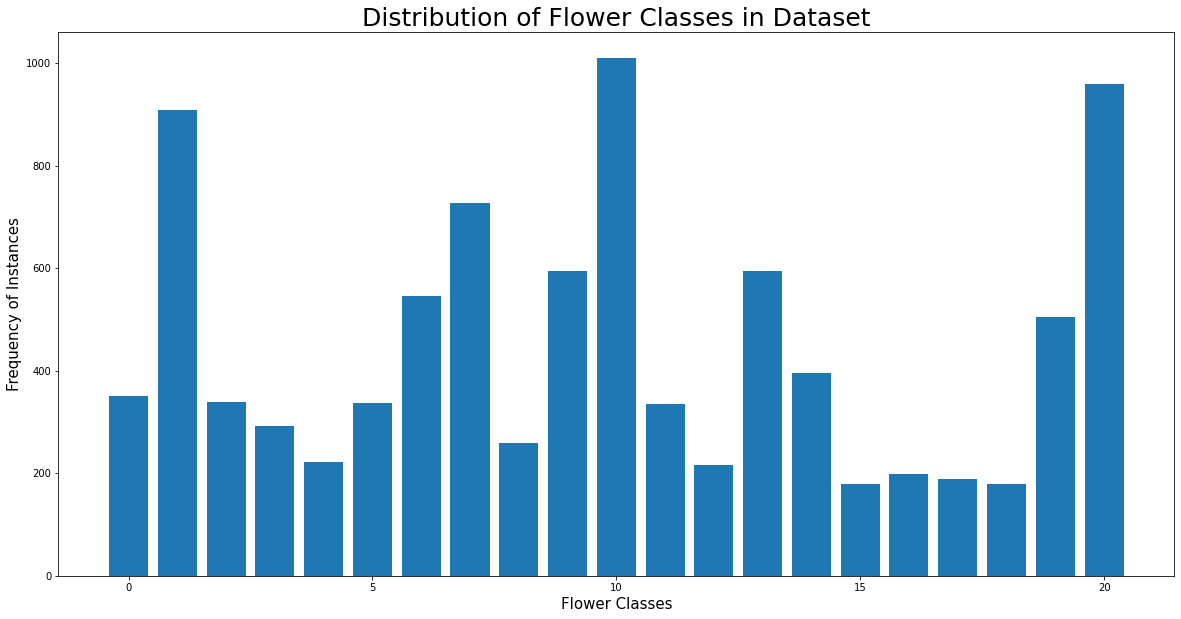

In [ ]:
plt.figure(figsize = (20, 10))
plt.bar(flowers_counts_.keys(), flowers_counts_.values())
plt.title("Distribution of Flower Classes in Dataset", fontsize = 25)
plt.xlabel("Flower Classes", fontsize = 15)
plt.ylabel("Frequency of Instances", fontsize = 15)

In [ ]:
train_ratio = 0.7
val_ratio = 0.1
ds_train, ds_val, ds_test = split_dataset(ds_take, size_of_ds, train_ratio, val_ratio)

In [ ]:
ds_train = get_trainning_dataset(ds_train)
ds_val = get_validation_dataset(ds_val)
ds_test = get_test_dataset(ds_test)

In [ ]:
# ds_train_serialized = ds_train.map(tf_serialize_example)
# writer = tf.data.experimental.TFRecordWriter('train.tfrecord')
# writer.write(ds_train_serialized)

In [ ]:
# ds_train = ds_train.unbatch()
# ds_train = ds_train.map(encode_image)

# ds_train_serialized = ds_train.map(tf_serialize_example)

In [ ]:
# def generator():
#   for features in ds_train:
#     yield serialize_example(*features)

In [ ]:
# serialized_ds_train = tf.data.Dataset.from_generator(
#     generator, output_types=tf.string, output_shapes=())

In [ ]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# serialized_ds_train

In [ ]:
# TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/combined_data_splitted/train"
# writer_train = tf.io.TFRecordWriter(TRAIN_PATH + "all.tfrec")
# writer_train.write(serialized_ds_train)

In [ ]:
# tf.data.experimental.save(
#     ds_train, "/content/drive/MyDrive/Colab_Notebooks/combined_data_splitted/train", compression=None, shard_func=None, checkpoint_args=None
# )

In [ ]:
# tf.data.experimental.save(
#     ds_val, "/content/drive/MyDrive/Colab_Notebooks/combined_data_splitted/validation", compression=None, shard_func=None, checkpoint_args=None
# )

In [ ]:
# tf.data.experimental.save(
#     ds_test, "/content/drive/MyDrive/Colab_Notebooks/combined_data_splitted/test", compression=None, shard_func=None, checkpoint_args=None
# )

In [ ]:
print(ds_train)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
# tfds.benchmark(ds_train, batch_size=32)

In [ ]:
t = next(iter(ds_train.unbatch().map(lambda image, label: label).batch(size_of_ds*train_ratio))).numpy()
unique_t, counts_t = np.unique(t, return_counts=True)
flowers_counts_t = dict(zip(unique_t, counts_t))
sum(flowers_counts_t.values())

6535

In [ ]:
# fc_t_name = {CLASSES[i]: v for i,v in flowers_counts_t.items()}
# fc_t_name

Text(0, 0.5, 'Frequency of Instances')

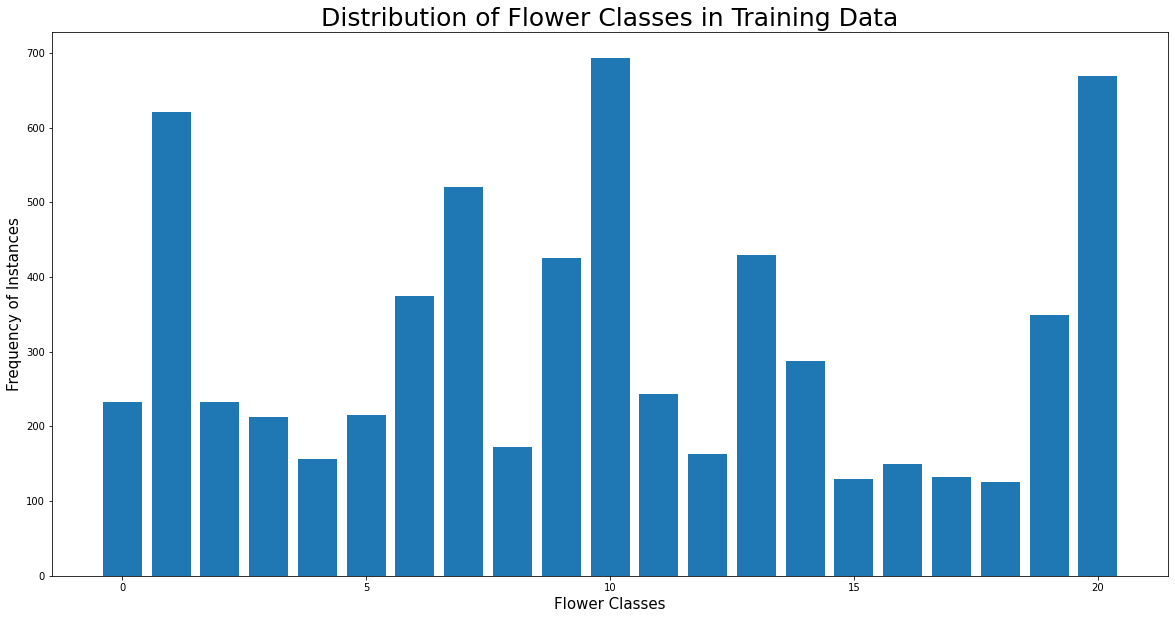

In [ ]:
plt.figure(figsize = (20, 10))
plt.bar(flowers_counts_t.keys(), flowers_counts_t.values())
plt.title("Distribution of Flower Classes in Training Data", fontsize = 25)
plt.xlabel("Flower Classes", fontsize = 15)
plt.ylabel("Frequency of Instances", fontsize = 15)

In [ ]:
v = next(iter(ds_val.unbatch().map(lambda image, label: label).batch(size_of_ds*val_ratio))).numpy()
unique_v, counts_v = np.unique(v, return_counts=True)
flowers_counts_v = dict(zip(unique_v, counts_v))
sum(flowers_counts_v.values())

933

In [ ]:
# fc_v_name = {CLASSES[i]: v for i,v in flowers_counts_v.items()}
# fc_v_name

Text(0, 0.5, 'Frequency of Instances')

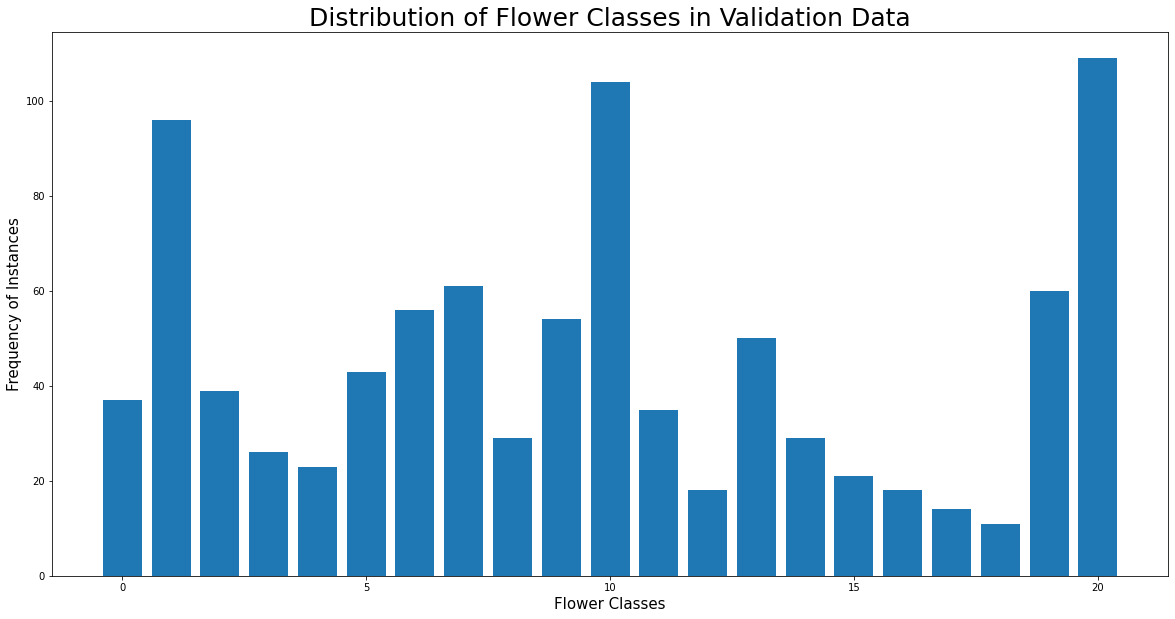

In [ ]:
plt.figure(figsize = (20, 10))
plt.bar(flowers_counts_v.keys(), flowers_counts_v.values())
plt.title("Distribution of Flower Classes in Validation Data", fontsize = 25)
plt.xlabel("Flower Classes", fontsize = 15)
plt.ylabel("Frequency of Instances", fontsize = 15)

In [ ]:
te = next(iter(ds_test.unbatch().map(lambda image, label: label).batch(size_of_ds*0.2))).numpy()
unique_te, counts_te = np.unique(te, return_counts=True)
flowers_counts_te = dict(zip(unique_te, counts_te))
sum(flowers_counts_te.values())

1867

In [ ]:
# fc_te_name = {CLASSES[i]: v for i,v in flowers_counts_te.items()}
# fc_te_name

Text(0, 0.5, 'Frequency of Instances')

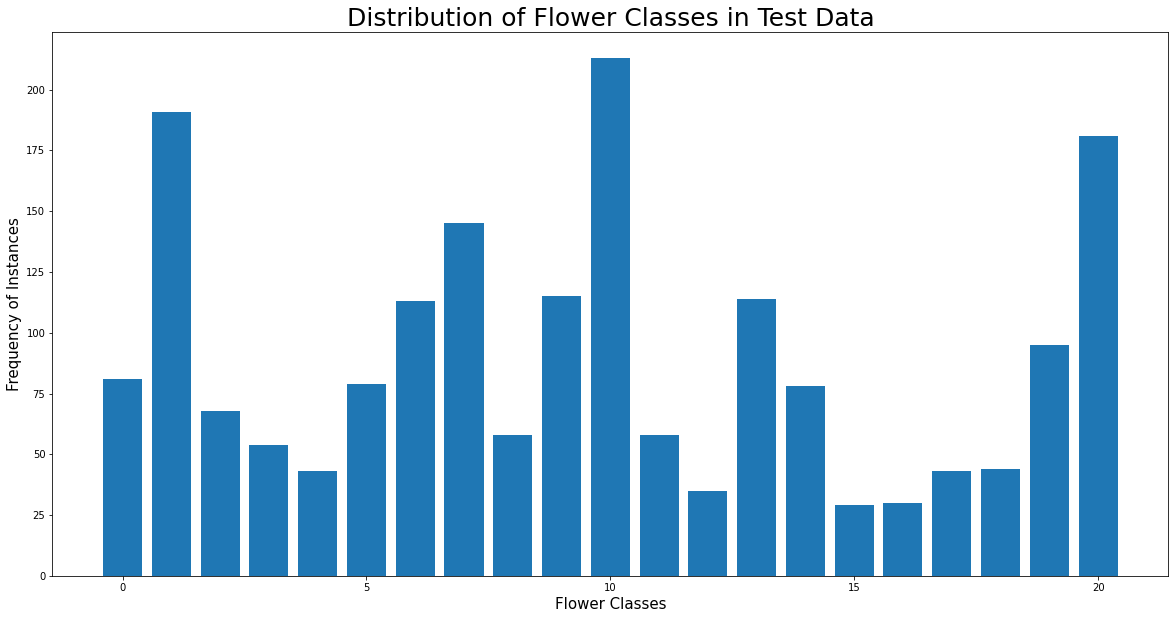

In [ ]:
plt.figure(figsize = (20, 10))
plt.bar(flowers_counts_te.keys(), flowers_counts_te.values())
plt.title("Distribution of Flower Classes in Test Data", fontsize = 25)
plt.xlabel("Flower Classes", fontsize = 15)
plt.ylabel("Frequency of Instances", fontsize = 15)

Traning model

In [ ]:
EPOCHS = 20
def exponential_lr(epoch,
                   start_lr = 0.1, min_lr = 0.001, max_lr = 0.5,
                   rampup_epochs = 5, sustain_epochs = 5,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)
def compile_cnn():
    model = models.Sequential()
    #from here, its just stacking layers, note that input shape ignores batch size
    #conv + maxpool layers
    model.add(layers.Conv2D(16, (3, 3), activation='relu',padding  = "same", input_shape=(192,192,3), data_format="channels_last"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding  = "same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding  = "same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding  = "same"))
    model.add(layers.MaxPooling2D((2, 2)))
    #fully-connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(21, activation = 'softmax'))
    #compile model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["sparse_categorical_accuracy"], run_eagerly=True)
    print("Architecture of the CNN: ")
    model.summary()
    return model

def train_cnn(model, train_set, valid_set, nr_epochs = EPOCHS, nr_steps_per_epoch = 6535 // BATCH_SIZE):
    #stops training if validation accuracy stops increasing by at least 0.01 for 10 epochs and use the best weights
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta = 0.05, mode = "max" ,patience=5, restore_best_weights=True)
    #Using the lr provided above
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)
    callback = [early_stop]
    history = model.fit(train_set, validation_data=valid_set, epochs = nr_epochs, steps_per_epoch=nr_steps_per_epoch, callbacks = callback)
    return model, history

def save_model(model):
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    model.save("/content/drive/MyDrive/Colab_Notebooks/ML models_dropped", options = save_locally)

In [ ]:
pretrain_model = compile_cnn()
trained_model, history = train_cnn(pretrain_model,ds_train,ds_val)

Architecture of the CNN: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.6])
plt.legend(loc='lower right')
plt.show()
